# Classifying Audio as Extremist Propaganda or Not 2

## Music Recognition Using STFTs

This notebook is split into the following main sections:

- [Global class and functions](#section_0)
- [Add extremist songs to database](#section_1)
- [Testing:](#section_2)
    - [1- Test pop songs](#section_3)
    - [2- Test pop and some extremist songs](#section_4)
    - [3- Test complete audio clips](#section_5)

In [2]:
# Initialization
%reset

import sys
# Possible installations required
#!{sys.executable} -m pip install pydub

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import warnings # Library for warnings manipulation (hiding mainly)
import os # Library for using operating system dependent functionality (checking current directory, files in directory, etc.)
import wave # Library for wav files manipulation
import glob # Library for file manipulation
import math # Library for Math operations
import scipy.io.wavfile as wav # Library for wav files manipulation
import numpy as np # Library for linear algebra and mathematical operations
import pandas as pd # Library to form dataframe
from pandas_ml import ConfusionMatrix # Library for confusion matrix (for model evaluation)
from sklearn.metrics import accuracy_score # Library to calculate accuracy
import matplotlib.pyplot as plt # Library for visualisations
import pickle # Library for saving/loading objects to/from disk
import librosa # Library for spectrograms
import librosa.display # Library for displaying spectrograms
import pylab # Library for scatter plots
import time # Library for time calculations

# Global Class and Functions <a class="anchor" id="section_0"></a>

This section holds:
- The hash table main class
- Function to get important peaks from spectrograms
- Function to hash the peak pairs into fingerprints
- Three Functions for identifying songs

In [4]:
# This class creates a hash table and modifies it accordingly

INITIAL_CAPACITY = 4000037 # Size of hash table (4,000,037)
    
class HashTable:
    
    def __init__(self):
        self.capacity = INITIAL_CAPACITY
        self.size = 0
        self.buckets = [None] * self.capacity
    
    # Hash a key
    def hash_key(self, key):
        hashsum = hash(key)
        hashsum = hashsum % self.capacity
        return hashsum
    
    # Insert values into buckets
    def insert(self, key, song_id, time):
        index = self.hash_key(key)
        check = self.buckets[index]
        if check is None:
            self.buckets[index] = [(key,song_id,time)]
            self.size += 1
            return
        else:
            array = self.buckets[index]
            array.append((key,song_id,time))
            self.buckets[index] = array
        
    # Find a certain bucket and get its contents
    def find(self, key):
        index = self.hash_key(key)
        check = self.buckets[index]
        if check is None:
            return None
        else:
            return self.buckets[index]

In [5]:
# Function to split an audio into 1 second chunks, generate spectrogram, get important peaks, and return them in a df
def get_important_peaks(samples, samples_req, num_chunks, sample_rate):
    
    # Initialise dataframe
    song_peaks_df = pd.DataFrame()
    song_peaks_df['Time'] = []
    song_peaks_df['Frequencies'] = []
    
    # Iterate through audio chunks
    for z in range(num_chunks):
        
        # Process the audio chunk by chunk (from frame number i to frame number i+1)
        chunk = samples[(z*samples_req):((z+1)*samples_req)]
        
        # Generate spectrogram
        spectrogram = np.abs(librosa.stft(chunk,n_fft=4096,win_length=4096,hop_length = 256))
        
        # Get important peaks
        max_peak = 0 # Initial max peak
        max_freq = 0 # Initial max frequency
        freq_band = ((sample_rate/2)/len(spectrogram)) # Calculate value of a single frequency band
        freq_ranges = [math.floor(i / freq_band) for i in [0,1600,3200,4800,6400]] # Required frequency ranges
        peak_results = [] # List to save the peak results

        for i in range(len(spectrogram[0])): # For every column (173 time columns)
            for j in range(len(freq_ranges)-1): # For every frequency range above
                for k in range(freq_ranges[j],freq_ranges[j+1]): # For every frequency band
                    
                    # Update the maximum peak detected in range
                    if (max_peak < (spectrogram[k])[i]):
                        max_peak = (spectrogram[k])[i]
                        max_freq = k
                        
                # Add maximum peak detected in range to list
                if (max_peak != 0):
                    peak_results.append(max_freq)
                max_peak = 0 # Reset max_peak
                max_freq = 0 # Reset max_freq
            
            # If peak_results holds four values, add frequencies and their respective time slot to the dataframe
            if (len(peak_results) == 4):
                feed_dict = {"Time":i+(z*len(spectrogram[0])),"Frequencies":peak_results} # Create dictionary
                song_peaks_df = song_peaks_df.append(feed_dict, ignore_index=True) # Add dictionary to dataframe
            peak_results = [] # Reset list for peak results
            
    # Return dataframe
    return song_peaks_df

# Function to hash the important peaks as a tuple
def hash_fingerprints(song_peaks_df, song_ID):
    
    # Iterate through every array
    for i in range(len(song_peaks_df)):
        array = (song_peaks_df['Frequencies'])[i] # The array we are currently working on
        time = (song_peaks_df['Time'])[i] # Time of array

        # If the array has a minimum size of 4, insert song_ID and timing to hash table
        if(len(array) == 4):
            hash_table.insert((array[0],array[1],array[2],array[3]),song_ID,time)
    
# Function to find matches in hash table and return a dataframe for said matches, as well as a list for potential song matches
def find_matches(sample_peaks_df):
    Matches_df = pd.DataFrame()
    freq_tuple = 0
    prev_freq_tuple = 0
    tuple_array = []
    potential_songs = []
    
    # Iterate through every array
    for i in range(len(sample_peaks_df)):
        sample_array = (sample_peaks_df['Frequencies'])[i] # The array we are currently working on
        time = (sample_peaks_df['Time'])[i] # Time of array
        
        # If there are four peaks (double checking)
        if(len(sample_array) == 4):
            freq_tuple = (sample_array[0],sample_array[1],sample_array[2],sample_array[3]) # Frequency tuple we will look for

            # If the current frequency tuple is not exactly as the one before
            if(freq_tuple != prev_freq_tuple):
                prev_freq_tuple = freq_tuple
                database_array = hash_table.find(freq_tuple) # Get the result array of hashing the tuple

                # If the result array contains frequencies
                if(database_array != None):

                    # Iterate through these frequency tuples
                    for j in range(len(database_array)):
                        if ((database_array[j])[0] == (freq_tuple)): # If sample frequency and databaset frequency are equal
                            tuple_array.append( ( (database_array[j])[1],(database_array[j])[2] ) ) # Add tuple
                            
                            # If the song ID is not already added to potential songs
                            if (check_potential_songs((database_array[j])[1], potential_songs) == False):
                                potential_songs.append((database_array[j])[1]) # Add song ID
                            
                    if (len(tuple_array)>0):
                        Matches_df = add_to_matches(Matches_df, tuple_array, i)
                    tuple_array = []
                    
    return Matches_df, potential_songs

# Function to add matching frequencies to a dataframe as a tuple consisting of the song ID and time of said frequencies
def add_to_matches(Matches_df, array, time):
    feed_dict = {"Sample_Timestamp":time,"Database_song_timestamp":array}
    Matches_df = Matches_df.append(feed_dict,ignore_index = True)
    return Matches_df

# Function to check the potential songs array (to make sure it is not appended with duplicates)
def check_potential_songs(song_ID, potential_songs):
    for i in range(len(potential_songs)):
        if (song_ID == potential_songs[i]):
            return True
    return False

# Function to identify the sample song from the matches dataframe
def identify_songs(Matches_df, potential_songs, threshold):
    
    decision = 0
    max_matches = 0
    
    
    # Create arrays for time offset calculations
    database_array = []
    sample_array = []
    
    # Iterate through potential song IDs
    for k in range(len(potential_songs)):
        
        # Iterate through all of the rows of matched frequencies
        for i in range(len(Matches_df)):
            
            # Iterate through all of the tuples of matched frequencies
            for j in range(len((Matches_df['Database_song_timestamp'])[i])):
                
                # If the tuple holds the Kth potential song ID, then investigate
                if((((Matches_df['Database_song_timestamp'])[i])[j])[0] == potential_songs[k]):
                    
                    database_array.append((((Matches_df['Database_song_timestamp'])[i])[j])[1]) # Timestamps in database
                    sample_array.append((Matches_df['Sample_Timestamp'])[i]) # Timestamps in sample song
        
        
        num_matches = produce_match(database_array, sample_array)            
        if (num_matches > max_matches):
            max_matches = num_matches
            decision = potential_songs[k]
        
        database_array = [] # Reset array
        sample_array = [] # Reset array
     
    if (decision == 0 or max_matches < threshold):
        return "No Match", max_matches
    else:
        return decision, max_matches
                    
                    
# Function to produce the final result (Either a song ID or "NO MATCH")
def produce_match(database_array, sample_array):
    
    # Create array for histogram
    hist_array = []
    for i in range(len(sample_array)):
        hist_array.append(database_array[i]-sample_array[i])
    
    array = np.histogram(hist_array, bins = 100)
    return max(array[0])

# Add extremist songs to database <a class="anchor" id="section_1"></a>

All wav files inside "Database Songs" folder are loaded in one by one and then:

- Separated into 1 second chunks
- Have their important peak tuples extracted and saved in a dataframe called "song_peaks_df"
- Fingerprinted by hashing every important peak tuple present "song_peaks_df"
- Save song details in a song dataframe

The final result would be a hash table that contains all the fingerprints of all the database songs. Also, each song processed is saved in a dataframe.

### There are some pre-processed hash tables and dataframes ready to be loaded from disk. Uncomment to load one of:

- Pop songs fingerprints hash table and songs dataframe
- Pop and some Extreme songs fingerprints hash table and songs dataframe
- All Extreme songs fingerprints hash table and songs dataframe

In [6]:
# 1- Load pop songs fingerprints hash table and songs dataframe
# try:
#     with open('Pop_Hash_Table.pkl', 'rb') as f:
#         hash_table = pickle.load(f)
#     database_songs_df = pd.read_pickle("Pop_database_songs_df")
# except OSError:
#     print("There is no hash table or dataframe file with that name")
# else:
#     print("hash table and dataframe have been loaded successfully")
    
# 2- Load pop and some extremist songs fingerprints hash table and songs dataframe
# try:
#     with open('Pop_Extreme_Hash_Table.pkl', 'rb') as f:
#         hash_table = pickle.load(f)
#     database_songs_df = pd.read_pickle("Pop_extreme_database_songs_df")
# except OSError:
#     print("There is no hash table or dataframe file with that name")
# else:
#     print("hash table and dataframe have been loaded successfully")
    
# 3- Load all extremist songs fingerprints hash table and songs dataframe
try:
    with open('Extreme_Hash_Table.pkl', 'rb') as f:
        hash_table = pickle.load(f)
    database_songs_df = pd.read_pickle("Extreme_database_songs_df")
except OSError:
    print("There is no hash table or dataframe file with that name")
else:
    print("hash table and dataframe have been loaded successfully")

# 4- Test Loading dataframe and hash table
# try:
#     with open('Test.pkl', 'rb') as f:
#         hash_table = pickle.load(f)
#     database_songs_df = pd.read_pickle("Test_df")
# except OSError:
#     print("There is no hash table or dataframe file with that name")
# else:
#     print("hash table and dataframe have been loaded successfully")

hash table and dataframe have been loaded successfully


### Otherwise process all songs present in "\\Database Songs" folder

In [177]:
database_path = os.getcwd() + "\\Database Songs" # Song database location
hash_table = HashTable() # Instantiate hash table
database_songs_df = pd.DataFrame() # Instantiate song details dataframe (to store song name and its ID)
song_count = 1 # Instantiate song count to save as song ID

print("Started hashing fingerprints of songs in database to hash table")

start_time = time.time() # For measuring the time it takes to fingerprint songs

# Iterate through each wav file inside the directory
for file in glob.glob(database_path + "\\*.wav"):
    feed_dict = {"Song_name":file.split('.wav')[0].split('\\')[-1],"Song_ID":song_count} # Create dictionary of song name and song ID
    database_songs_df = database_songs_df.append(feed_dict, ignore_index = True) # Save dictionary to dataframe
    samples, sample_rate = librosa.load(file, sr=44100) # Get audio samples and sample rate
    duration = len(samples) / float(sample_rate) # Get the duration of audio

    # Check if the audio can at least be split into 2 chunks
    if (duration > 1):
        samples_req = int(sample_rate) * 1 # The required number of samples in a single chunk (1 second chosen)
        num_chunks = math.floor(len(samples)/float(samples_req)) # The number of chunks the audio will be split into

        # Get important peaks
        song_peaks_df = pd.DataFrame()
        song_peaks_df = get_important_peaks(samples, samples_req, num_chunks, sample_rate)
        
        # Hash peaks into hash table
        hash_fingerprints(song_peaks_df, song_count)
        
    song_count +=1 # Increment song count to have as next song ID

elapsed_time = time.time() - start_time # End time

print("Hashing complete. Song fingerprints have been generated")
print("The time required to add the %s songs present in the folder is %s seconds" % (song_count-1,elapsed_time))
print("The size of our hash table is %s" % (hash_table.size))

Started hashing fingerprints of songs in database to hash table
Hashing complete. Song fingerprints have been generated
The time required to add the 11 songs present in the folder is 543.5546805858612 seconds
The size of our hash table is 266610


### Save fingerprint hash table and dataframe to file - Uncomment one of the sections to save

In [178]:
# Save fingerprint hashtable to file (In order to load in when needed)

# 1- Pop Songs:
# with open('Pop_Hash_Table.pkl', 'wb') as output:
#    pickle.dump(hash_table, output, pickle.HIGHEST_PROTOCOL)
# database_songs_df.to_pickle("Pop_database_songs_df") # Save to disk
    
# 2- Pop + Few Extremist Songs:
#with open('Pop_Extreme_Hash_Table.pkl', 'wb') as output:
#    pickle.dump(hash_table, output, pickle.HIGHEST_PROTOCOL)
#database_songs_df.to_pickle("Pop_extreme_database_songs_df") # Save to disk

# 3- All Extremist Songs:
with open('Extreme_Hash_Table.pkl', 'wb') as output:
    pickle.dump(hash_table, output, pickle.HIGHEST_PROTOCOL)
database_songs_df.to_pickle("Extreme_database_songs_df") # Save to disk

# 4- Test Saving Tables:
# with open('Test.pkl', 'wb') as output:
#    pickle.dump(hash_table, output, pickle.HIGHEST_PROTOCOL)
# database_songs_df.to_pickle("Test_df") # Save to disk

# Testing <a class="anchor" id="section_2"></a>

In [7]:
def Test_Clips(directory_path, test_results, threshold):
    # Iterate through each wav file inside the directory
    for file in glob.glob(test_directory_path + "\\*.wav"):
        samples, sample_rate = librosa.load(file, sr=44100) # Get audio samples and sample rate
        duration = len(samples) / float(sample_rate) # Get the duration of audio
        file_name = (file.split('.wav')[0].split('\\')[-1]) # Get file name
        
        print(file_name)

        start_time = time.time() # For measuring the time it takes to identify the specific song

        # Check if the audio can at least be split into 2 chunks
        if (duration >= 1):
            samples_req = int(sample_rate) * 1 # The required number of samples in a single chunk (1 second chosen)
            num_chunks = math.floor(len(samples)/float(samples_req)) # The number of chunks the audio will be split into

            # Get important peaks
            sample_peaks_df = pd.DataFrame()
            sample_peaks_df = get_important_peaks(samples, samples_req, num_chunks, sample_rate)

        # Get dataframe of matches for each song, and the number of potential songs
        Matches_df, potential_songs = find_matches(sample_peaks_df)

        # Check all potential songs. Decision song is the one with most matches (which should be above a certain threshold)
        decision, max_matches = identify_songs(Matches_df, potential_songs, threshold)
        print(decision)
        print(max_matches)
        print("----------------------")

#         if (decision != "No Matches"):
#             for i in range(len(database_songs_df['Song_ID'])):
#                 if (decision == (database_songs_df['Song_ID'])[i]):
#                     decision = (database_songs_df['Song_name'])[i]

        elapsed_time = time.time() - start_time # End time
    
        print(elapsed_time)

        feed_dict = {"file_name":file_name,"potential_songs":potential_songs,"decision":decision,"amount of matches":max_matches,"Duration of Sample":duration,"Time to recognise": elapsed_time}
        test_results = test_results.append(feed_dict, ignore_index = True)
    return test_results

# 1- Test pop songs <a class="anchor" id="section_3"></a>

In [8]:
test_directory_path = os.getcwd() + "\\Test Pop Songs" # Test songs location
test_results  = pd.DataFrame() # Instantiate dataframe for test results

print("Testing")

test_results = Test_Clips(test_directory_path, test_results, 65)
test_results.to_csv("pop_songs_results.csv", sep=',', encoding='utf-8', index=False); # Save to disk

print("Results:")
test_results

Testing
blurred-lines-clean-1
2
1649
----------------------
3.4494025707244873
blurred-lines-noise-1
2
348
----------------------
2.3008666038513184
blurred-lines-noise-2
2
100
----------------------
2.2080934047698975
cups-clean-1
4
1451
----------------------
2.9550797939300537
cups-clean-2
4
1665
----------------------
3.2802464962005615
final-countdown-clean-1
7
1510
----------------------
3.277250289916992
final-countdown-noise-1
7
900
----------------------
2.8384366035461426
final-countdown-noise-2
7
499
----------------------
2.4903669357299805
girls-just-want-to-have-fun-clean-1
5
1004
----------------------
1.8311030864715576
girls-just-want-to-have-fun-noise-1
5
966
----------------------
2.813472270965576
girls-just-want-to-have-fun-noise-2
5
636
----------------------
2.614014148712158
NO_MATCH-bohemian-rhapsody
No Match
7
----------------------
1.7353627681732178
NO_MATCH-I-want-to-break-free
No Match
2
----------------------
1.7333695888519287
NO_MATCH-Smells-Like-Teen-S

,Duration of Sample,Time to recognise,amount of matches,decision,file_name,potential_songs
0,10.643991,3.449403,1649.0,2,blurred-lines-clean-1,"[2, 10, 1, 8, 5, 6]"
1,10.643991,2.300867,348.0,2,blurred-lines-noise-1,"[2, 1, 7, 6, 8]"
2,10.643991,2.208093,100.0,2,blurred-lines-noise-2,"[2, 7, 10]"
3,10.643991,2.955080,1451.0,4,cups-clean-1,"[4, 6, 10, 3]"
4,10.643991,3.280246,1665.0,4,cups-clean-2,"[4, 10, 9, 3, 7, 11, 6, 2]"
5,11.344671,3.277250,1510.0,7,final-countdown-clean-1,"[7, 8, 9, 5]"
6,11.344671,2.838437,900.0,7,final-countdown-noise-1,"[7, 8, 1, 11, 5, 9, 6]"
7,11.344671,2.490367,499.0,7,final-countdown-noise-2,"[7, 8, 6, 9, 11, 5]"
8,6.673333,1.831103,1004.0,5,girls-just-want-to-have-fun-clean-1,"[5, 10, 4, 8, 3, 7, 6, 11]"
9,11.211224,2.813472,966.0,5,girls-just-want-to-have-fun-noise-1,"[3, 5, 8, 7, 2, 9]"


# 2- Test pop and some extreme songs <a class="anchor" id="section_4"></a>

In [22]:
test_directory_path = os.getcwd() + "\\Test Pop Extremist Songs" # Test songs location
test_results  = pd.DataFrame() # Instantiate dataframe for test results

print("Testing")

test_results = Test_Clips(test_directory_path, test_results, 65)
test_results.to_csv("pop_extremist_songs_results.csv", sep=',', encoding='utf-8', index=False); # Save to disk

print("Results:")
test_results

Testing
Results:


,Duration of Sample,Time to recognise,amount of matches,decision,file_name,potential_songs
0,3.570249,1.104047,215.0,1جاَنِي خَبَر,1جاَنِي خَبَر-clean-1,"[286, 1, 148, 180, 181, 218, 126, 170, 65, 300..."
1,4.270952,0.822800,4.0,No Match,1جاَنِي خَبَر-noise-1-Hard,"[102, 26, 116, 69, 73, 117, 141, 66, 259, 1, 2..."
2,6.740068,1.297523,19.0,No Match,1جاَنِي خَبَر-noise-3-VERY-Hard,"[217, 106, 141, 182, 208, 1, 270, 65, 133, 30,..."
3,3.203197,1.527893,420.0,AJNAD - OMMATI,AJNAD - OMMATI-clean-1,"[2, 214, 293, 298, 281, 231, 192, 124, 157, 24..."
4,4.170839,0.777922,1.0,No Match,AJNAD - OMMATI-noise-1-Hard,"[226, 229, 277, 297, 32, 11, 116, 5, 97, 143, ..."
5,6.740068,1.409239,119.0,AJNAD - OMMATI,AJNAD - OMMATI-noise-3-Very-Hard,"[137, 124, 2, 123, 100, 50, 27, 32, 178, 306, ..."
6,10.643991,1.910896,2.0,No Match,blurred-lines-clean-1,"[240, 41, 133, 154, 7, 194, 74, 199, 209, 14, ..."
7,10.643991,1.940821,2.0,No Match,blurred-lines-noise-1,"[297, 73, 85, 88, 59, 133, 115, 173, 49, 208, ..."
8,10.643991,1.966737,3.0,No Match,blurred-lines-noise-2,"[137, 9, 182, 119, 120, 218, 251, 116, 7, 15, ..."
9,10.643991,1.919865,2.0,No Match,cups-clean-1,"[5, 198, 224, 220, 194, 254, 170, 176, 28, 8, ..."


In [11]:
test_results2 = pd.read_csv('pop_extremist_songs_results.csv')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.expand_frame_repr', False):
    #display(test_results2)
test_results2['Duration of Sample'].mean()
test_results2['Time to recognise'].mean()

2.201512120320247

In [13]:
test_results2

,Duration of Sample,Time to recognise,amount of matches,decision,file_name,potential_songs
0,3.570249,1.104047,215.0,1جاَنِي خَبَر,1جاَنِي خَبَر-clean-1,"[286, 1, 148, 180, 181, 218, 126, 170, 65, 300..."
1,4.270952,0.822800,4.0,No Match,1جاَنِي خَبَر-noise-1-Hard,"[102, 26, 116, 69, 73, 117, 141, 66, 259, 1, 2..."
2,6.740068,1.297523,19.0,No Match,1جاَنِي خَبَر-noise-3-VERY-Hard,"[217, 106, 141, 182, 208, 1, 270, 65, 133, 30,..."
3,3.203197,1.527893,420.0,AJNAD - OMMATI,AJNAD - OMMATI-clean-1,"[2, 214, 293, 298, 281, 231, 192, 124, 157, 24..."
4,4.170839,0.777922,1.0,No Match,AJNAD - OMMATI-noise-1-Hard,"[226, 229, 277, 297, 32, 11, 116, 5, 97, 143, ..."
5,6.740068,1.409239,119.0,AJNAD - OMMATI,AJNAD - OMMATI-noise-3-Very-Hard,"[137, 124, 2, 123, 100, 50, 27, 32, 178, 306, ..."
6,10.643991,1.910896,2.0,No Match,blurred-lines-clean-1,"[240, 41, 133, 154, 7, 194, 74, 199, 209, 14, ..."
7,10.643991,1.940821,2.0,No Match,blurred-lines-noise-1,"[297, 73, 85, 88, 59, 133, 115, 173, 49, 208, ..."
8,10.643991,1.966737,3.0,No Match,blurred-lines-noise-2,"[137, 9, 182, 119, 120, 218, 251, 116, 7, 15, ..."
9,10.643991,1.919865,2.0,No Match,cups-clean-1,"[5, 198, 224, 220, 194, 254, 170, 176, 28, 8, ..."


# 3- Test complete audio clips <a class="anchor" id="section_5"></a>

In [63]:
test_directory_path = os.getcwd() + "\\Test Complete Audio Clips" # Test songs location
test_results  = pd.DataFrame() # Instantiate dataframe for test results

print("Testing")

test_results = Test_Clips(test_directory_path, test_results, 250)
test_results.to_csv("whole_clips_results.csv", sep=',', encoding='utf-8', index=False); # Save to disk

print("Results:")
test_results

Testing
N1
No Match
16
----------------------
249.03222632408142
N10
No Match
55
----------------------
13885.902780771255
N100
No Match
37
----------------------
73.34771537780762
N12
No Match
34
----------------------
735.3447525501251
N13
No Match
32
----------------------
3198.379946231842
N14
No Match
60
----------------------
147.68019771575928
N15
No Match
85
----------------------
11640.84665465355
N16
No Match
21
----------------------
226.86879706382751
N17
48
239
----------------------
3616.559551000595
N18
No Match
58
----------------------
1313.6840410232544
N19
No Match
70
----------------------
1568.5103540420532
N2
No Match
17
----------------------
202.59893560409546
N21
No Match
9
----------------------
239.01039004325867
N23
No Match
87
----------------------
542.7816345691681
N24
No Match
12
----------------------
135.19718074798584
N3
No Match
13
----------------------
157.26326823234558
N31
No Match
28
----------------------
634.8991968631744
N32
110
190
---------

,Duration of Sample,Time to recognise,amount of matches,decision,file_name,potential_songs
0,651.923447,249.032226,16.0,No Match,N1,"[7, 9, 73, 209, 215, 59, 148, 158, 4, 252, 71,..."
1,5815.530522,13885.902781,55.0,No Match,N10,"[33, 4, 178, 201, 195, 224, 35, 266, 73, 230, ..."
2,266.309660,73.347715,37.0,No Match,N100,"[122, 134, 254, 244, 224, 277, 186, 180, 233, ..."
3,1276.656327,735.344753,34.0,No Match,N12,"[174, 3, 12, 24, 10, 97, 4, 285, 197, 213, 20,..."
4,2967.700317,3198.379946,32.0,No Match,N13,"[19, 292, 266, 305, 240, 122, 25, 296, 212, 28..."
5,505.637732,147.680198,60.0,No Match,N14,"[183, 137, 164, 293, 128, 241, 35, 124, 83, 52..."
6,5759.499320,11640.846655,85.0,No Match,N15,"[47, 122, 145, 14, 48, 154, 8, 89, 205, 35, 19..."
7,620.042449,226.868797,21.0,No Match,N16,"[37, 215, 145, 297, 308, 223, 109, 241, 15, 7,..."
8,2605.905850,3616.559551,239.0,48,N17,"[220, 253, 252, 149, 1, 78, 122, 276, 286, 125..."
9,1819.933605,1313.684041,58.0,No Match,N18,"[219, 41, 7, 52, 48, 82, 33, 284, 30, 193, 29,..."


In [260]:
test_results.to_pickle("whole_clips_results_df") # Save to disk

In [14]:
test_results = pd.read_pickle("whole_clips_results_df") # load from disk
test_results['Duration of Sample'] = test_results['Duration of Sample'] / 60; # Convert to minutes
test_results['Time to recognise'] = test_results['Time to recognise'] / 60; # Convert to minutes
test_results

,Duration of Sample,Time to recognise,amount of matches,decision,file_name,potential_songs
0,10.865391,4.150537,16.0,No Match,N1,"[7, 9, 73, 209, 215, 59, 148, 158, 4, 252, 71,..."
1,96.925509,231.431713,55.0,No Match,N10,"[33, 4, 178, 201, 195, 224, 35, 266, 73, 230, ..."
2,4.438494,1.222462,37.0,No Match,N100,"[122, 134, 254, 244, 224, 277, 186, 180, 233, ..."
3,21.277605,12.255746,34.0,No Match,N12,"[174, 3, 12, 24, 10, 97, 4, 285, 197, 213, 20,..."
4,49.461672,53.306332,32.0,No Match,N13,"[19, 292, 266, 305, 240, 122, 25, 296, 212, 28..."
5,8.427296,2.461337,60.0,No Match,N14,"[183, 137, 164, 293, 128, 241, 35, 124, 83, 52..."
6,95.991655,194.014111,85.0,No Match,N15,"[47, 122, 145, 14, 48, 154, 8, 89, 205, 35, 19..."
7,10.334041,3.781147,21.0,No Match,N16,"[37, 215, 145, 297, 308, 223, 109, 241, 15, 7,..."
8,43.431764,60.275993,239.0,No Match,N17,"[220, 253, 252, 149, 1, 78, 122, 276, 286, 125..."
9,30.332227,21.894734,58.0,No Match,N18,"[219, 41, 7, 52, 48, 82, 33, 284, 30, 193, 29,..."


In [13]:
test = pd.read_csv('whole_clips_results.csv')
test[30:]

,Duration of Sample,Time to recognise,amount of matches,decision,file_name,potential_songs
30,6.583244,1.644587,32.0,No Match,N72,"[267, 215, 53, 158, 229, 194, 91, 172, 73, 230..."
31,21.428559,10.743419,30.0,No Match,N8,"[182, 204, 9, 30, 254, 239, 233, 89, 266, 279,..."
32,12.606887,3.283779,224.0,No Match,N9,"[69, 178, 143, 8, 299, 238, 110, 277, 249, 193..."
33,5.401348,2.018283,102.0,No Match,N90,"[35, 104, 123, 15, 276, 44, 265, 262, 285, 90,..."
34,10.305790,3.452827,16.0,No Match,N97,"[263, 79, 59, 31, 174, 46, 155, 48, 203, 202, ..."
35,9.989611,3.163334,17.0,No Match,N99,"[186, 279, 175, 137, 5, 11, 228, 56, 76, 209, ..."
36,0.533311,0.221357,252.0,285,p-video-1,"[22, 135, 176, 259, 183, 181, 294, 228, 299, 2..."
37,4.256475,1.440844,294.0,239,p-video-2,"[63, 155, 200, 61, 47, 77, 13, 261, 25, 29, 14..."
38,3.783780,1.216861,347.0,62,p-video-3,"[91, 101, 126, 30, 219, 115, 119, 19, 293, 9, ..."
39,0.574463,0.140308,50.0,No Match,p-video-4,"[206, 27, 194, 88, 221, 117, 15, 1, 119, 161, ..."


Text(0, 0.5, 'Time to Recognise (minutes)')

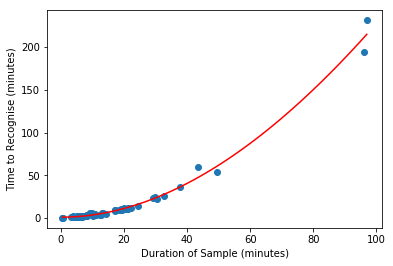

In [44]:
# Get duration/time relationship
z = np.polyfit(test_results['Duration of Sample'], test_results['Time to recognise'], 3) # Get coefficients
f = np.poly1d(z) # Create function with coefficients
x_new = np.linspace((test_results['Duration of Sample']).min(), (test_results['Duration of Sample']).max(), 50) # New datapoints
y_new = f(x_new) # New y datapoints
plt.plot(test_results['Duration of Sample'],test_results['Time to recognise'],'o', x_new, y_new,'r') # Plot both sets
plt.xlabel('Duration of Sample (minutes)') # Plot y label
plt.ylabel('Time to Recognise (minutes)') # Plot x label

In [42]:
print(z)

[-3.18645809e-05  2.57780042e-02  8.21877566e-03  9.66451550e-01]


# Validation Below (Just for testing - Not a meaningful section of the code)

In [236]:
audio_path = os.getcwd() + "\\blurred-lines-noise-2.wav"
samples, sample_rate = librosa.load(audio_path, sr=44100)
duration = len(samples) / float(sample_rate) # Get the duration of audio


# Check if the audio can at least be split into 2 chunks
if (duration > 1):
    samples_req = int(sample_rate) * 1 # The required number of samples in a single chunk (1 second chosen)
    num_chunks = math.floor(len(samples)/float(samples_req)) # The number of chunks the audio will be split into
    
    # Get important peaks
    sample_peaks_df = pd.DataFrame
    sample_peaks_df = get_important_peaks(samples, samples_req, num_chunks, sample_rate)
    
    

In [237]:
Matches_df, potential_songs = find_matches(sample_peaks_df)

In [238]:
Matches_df;

In [239]:
potential_songs

[2, 7, 10]

In [240]:
# Create arrays for scatter plot
database_array = []
sample_array = []
for i in range(len(Matches_df)):
    for j in range(len((Matches_df['Database_song_timestamp'])[i])):
        database_array.append((((Matches_df['Database_song_timestamp'])[i])[j])[1])
        sample_array.append((Matches_df['Sample_Timestamp'])[i])

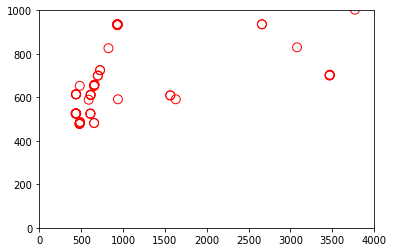

In [241]:
axes = plt.gca()
axes.set_ylim([0,1000])
axes.set_xlim([0,4000])
plt.scatter(database_array,sample_array,s=80, facecolors='none', edgecolors='r')
plt.show()


In [242]:
# Create array for histogram
hist_array = []
for i in range(len(sample_array)):
    hist_array.append(database_array[i]-sample_array[i])

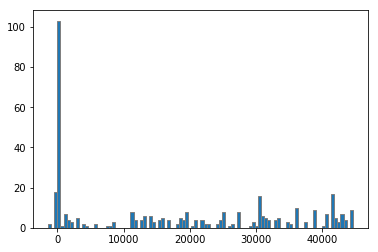

In [243]:
plt.hist(hist_array,edgecolor='gray',bins=100)
plt.show()

In [226]:
array = np.histogram(hist_array, bins = 100)
max(array[0])

1649